In [ ]:
import tensorflow as tf
#Check if GPU is in use.
print(f"tensorflow GPU version: {tf.__version__}")

In [ ]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
import datetime
# from autoencoder import Denoise
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
import cv2
import time
import string
import requests
import urllib.request

from utils import *

In [ ]:
#Clear the GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:

# Generation resolution - Must be square 

GENERATE_RES = 2 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 224*3 # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED = 54
SEED_SIZE = 100

# Configuration
DATA_PATH = 'Data/Dataset1000/'
EPOCHS = 50
BATCH_SIZE = 1
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

In [15]:
class Denoise(Model):
  def __init__(self, in_shp):
    """
    This is our generator/autoencoder model the will perform image generation and watermark removal.
    """
    super(Denoise, self).__init__()
    # Define the encoder function that will perform image compression and will do feature extraction
    self.encoder = tf.keras.Sequential([          
      layers.Input(shape=(in_shp, in_shp, 3)),
      layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),      
      ])

    # Define the decoder function that will perfoorm image de-compression and extrapolate the original features from the output of the encoder
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(256, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same')
      ])
    
    
  def call(self, x):
    """
    Compiler function for the autoencoder model
    """
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [16]:
def root_mean_squared_error(y_true, y_pred):
        """
        A custom error function for our neural network.
        """
        return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true))) # Use mean squared error applied to each pixel of the image

def get_random_string(length):
        """
        Helper function to generate a random string.
        """
        letters = string.ascii_lowercase
        result_str = ''.join(rnd.choice(letters) for i in range(length))
        return result_str

In [17]:
# Create an instance of our autoencoder model
autoencoder = Denoise(GENERATE_SQUARE)
autoencoder.compile(optimizer='adam', loss=root_mean_squared_error) # Compile with adam optimizer
weight_path = "User_Weights/_pretrained_weights0005.h5" # Specify the path to the weight checkpoint
autoencoder.build((1,GENERATE_SQUARE,GENERATE_SQUARE,3)) # Fully build the autoencoder network
autoencoder.load_weights(weight_path) # Load the weight checkpoint into the network

In [18]:
# Create data generators to flow images from directory. This improves the speed of training
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
gen = test_datagen.flow_from_directory(
    directory="Data/Dataset1000/Test/WM_Images/",
    target_size=(GENERATE_SQUARE, GENERATE_SQUARE),
    color_mode="rgb",
    batch_size=1,
    class_mode="input",
    shuffle=True)

Found 25 images belonging to 1 classes.


In [19]:
def perform_prediction (model, gen):
    """
    Performs prediction on a single image batch.
    """
    data_list = []
    batch_index = 0

    data = gen.next() #get the next batch
    print(data[0].shape)
    data_list.append(data[0]) #append the X from the batch onto the data list
    batch_index = batch_index + 1 
    print(data_list[0].shape)
    predicted = model.predict(data_list[0]) # run the prediction with the model
    predicted_twice = model.predict(predicted) # recycle the prediction to see what happens
    predicted_thrice = model.predict(predicted_twice) # recycle once more

    return [data[1][0], predicted[0], predicted_twice[0], predicted_thrice[0]]

(1, 672, 672, 3)
(1, 672, 672, 3)


&lt;matplotlib.image.AxesImage at 0x263a2dbf788&gt;

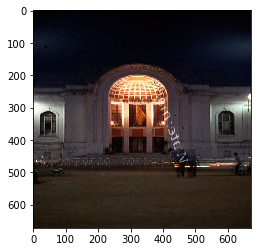

In [24]:
full_prediction = perform_prediction(autoencoder, gen)
plt.imshow(full_prediction[0])

&lt;matplotlib.image.AxesImage at 0x263a2b82408&gt;

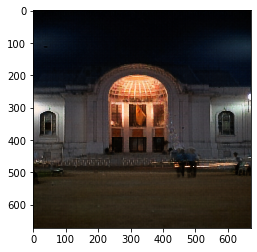

In [25]:
plt.imshow(full_prediction[1])

&lt;matplotlib.image.AxesImage at 0x263a1340d48&gt;

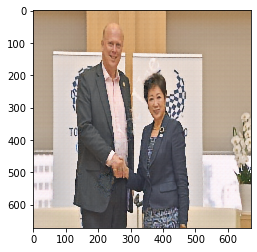

In [22]:
plt.imshow(full_prediction[1])

&lt;matplotlib.image.AxesImage at 0x263a2b02e48&gt;

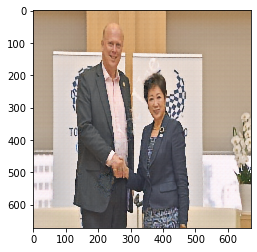

In [23]:
plt.imshow(full_prediction[1])

In [26]:
def predict_all (generator, out_dir, model):
    """
    Predict and save the entire directory.
    """
    for i in range(generator.n):
        pred = perform_prediction(model, generator)
        rnd_string = get_random_string(10)
        print(rnd_string)
        cv2.imwrite(f"Output/im_{rnd_string}_original.png", cv2.cvtColor(pred[0]*255., cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"Output/im_{rnd_string}_1.png", cv2.cvtColor( pred[1]*255., cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"Output/im_{rnd_string}_2.png", cv2.cvtColor( pred[2]*255., cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"Output/im_{rnd_string}_3.png", cv2.cvtColor( pred[3]*255., cv2.COLOR_RGB2BGR))


In [27]:
predict_all(gen, "Output/", autoencoder)

(1, 672, 672, 3)
(1, 672, 672, 3)
qhtxoavxjv
(1, 672, 672, 3)
(1, 672, 672, 3)
txkiigvqtk
(1, 672, 672, 3)
(1, 672, 672, 3)
ulzuzfiybg
(1, 672, 672, 3)
(1, 672, 672, 3)
hinnjovkrn
(1, 672, 672, 3)
(1, 672, 672, 3)
nclpzyisbb
(1, 672, 672, 3)
(1, 672, 672, 3)
gsspzezzxx
(1, 672, 672, 3)
(1, 672, 672, 3)
qdxwgowahg
(1, 672, 672, 3)
(1, 672, 672, 3)
nartzsssgs
(1, 672, 672, 3)
(1, 672, 672, 3)
vwtpxuaqnm
(1, 672, 672, 3)
(1, 672, 672, 3)
ysonmjankr
(1, 672, 672, 3)
(1, 672, 672, 3)
ffvruvaqir
(1, 672, 672, 3)
(1, 672, 672, 3)
saphomsbvu
(1, 672, 672, 3)
(1, 672, 672, 3)
wrrbetzdgn
(1, 672, 672, 3)
(1, 672, 672, 3)
zaqaswfomn
(1, 672, 672, 3)
(1, 672, 672, 3)
psioqgnhgc
(1, 672, 672, 3)
(1, 672, 672, 3)
oizzxjvwtb
(1, 672, 672, 3)
(1, 672, 672, 3)
xwjdmdtmdr
(1, 672, 672, 3)
(1, 672, 672, 3)
mjzitzemgo
(1, 672, 672, 3)
(1, 672, 672, 3)
bontkyugsl
(1, 672, 672, 3)
(1, 672, 672, 3)
rdujxbnbdx
(1, 672, 672, 3)
(1, 672, 672, 3)
pkilrycdyf
(1, 672, 672, 3)
(1, 672, 672, 3)
zpmncndhxe
(1, 672, 6